# Exercise 8. Mining Social Graphs

## Text, Web and Social Media Analytics Lab

In this exercise, we will conduct network analytics on a 2018 State of the Union Retweet dataset, which can be found [here](https://assets.datacamp.com/production/repositories/2161/datasets/51e79668580cdb86969c2c625172eaed2ded684a/sotu2018-rt.csv). We will analyze the relationship between the users both visually and using network metrics. 

We will perform the following steps: 
- Network Creation
- Network Visualization
- Degree Centrality
- Betweenness Centrality

We first install and import all the packages we will be using for this exercise.

In [1]:
!pip install tweet-preprocessor

import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from wordcloud import WordCloud, STOPWORDS
from preprocessor.api import clean

We load the dataset by reading the csv file directly from the URL. We then show the head of the dataset to understand how the data looks. 

In [2]:
url = 'https://assets.datacamp.com/production/repositories/2161/datasets/51e79668580cdb86969c2c625172eaed2ded684a/sotu2018-rt.csv'
sotu_retweets = pd.read_csv(url)

sotu_retweets.head()

,contributors,coordinates,created_at,extended_entities,favorite_count,favorited,filter_level,geo,id,id_str,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,is_quote_status,lang,place,possibly_sensitive,quote_count,quoted_status-extended_tweet-full_text,quoted_status-text,quoted_status-user-screen_name,quoted_status_id,quoted_status_id_str,reply_count,retweet_count,retweeted,retweeted_status-extended_tweet-full_text,retweeted_status-text,retweeted_status-user-screen_name,source,text,timestamp_ms,truncated,user-screen_name,withheld_in_countries
0,NaN,NaN,Wed Jan 31 03:51:59 +0000 2018,NaN,0,False,low,NaN,958548390052179968,958548390052179968,NaN,NaN,NaN,NaN,NaN,False,en,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,0,0,False,A PERFECT ANALOGY:\n\nSeveral democrats are br...,A PERFECT ANALOGY:\n\nSeveral democrats are br...,ScottPresler,"<a href=""http://twitter.com/download/iphone"" r...",RT @ScottPresler: A PERFECT ANALOGY:\n\nSevera...,1517370719813,False,MatthewJAld,NaN
1,NaN,NaN,Wed Jan 31 03:55:33 +0000 2018,NaN,0,False,low,NaN,958549287285215232,958549287285215232,NaN,NaN,NaN,NaN,NaN,False,en,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,0,0,False,NaN,President Trump invited families of Americans ...,RealJack,"<a href=""http://twitter.com/download/android"" ...",RT @RealJack: President Trump invited families...,1517370933730,False,broussard_sr,NaN
2,NaN,NaN,Wed Jan 31 03:09:22 +0000 2018,NaN,0,False,low,NaN,958537665334296577,958537665334296577,NaN,NaN,NaN,NaN,NaN,False,en,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,0,0,False,NaN,Don't you be fooled by any of his White Suprem...,UNITEDWEDREAM,"<a href=""http://twitter.com/download/iphone"" r...",RT @UNITEDWEDREAM: Don't you be fooled by any ...,1517368162841,False,CLSTEPHANY,NaN
3,NaN,NaN,Wed Jan 31 02:36:19 +0000 2018,NaN,0,False,low,NaN,958529347828305921,958529347828305921,NaN,NaN,NaN,NaN,NaN,False,en,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,0,0,False,NaN,Uh-oh. Our president mentioned the FIRST and S...,TomiLahren,"<a href=""http://twitter.com/download/iphone"" r...",RT @TomiLahren: Uh-oh. Our president mentioned...,1517366179793,False,DAWNSTUTESMAN,NaN
4,NaN,NaN,Wed Jan 31 02:46:24 +0000 2018,NaN,0,False,low,NaN,958531885424173057,958531885424173057,NaN,NaN,NaN,NaN,NaN,False,en,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,0,0,False,"Tonight isn't about memos, fake news, free thi...","Tonight isn't about memos, fake news, free thi...",TomiLahren,"<a href=""http://twitter.com/download/android"" ...","RT @TomiLahren: Tonight isn't about memos, fak...",1517366784803,False,SCischk,NaN


We filter only the tweets that refer to FoxNews, either by tweets being retweeted by them or by someone retweeting their tweets. We show again the head of the data to check that the filtering work well.

In [3]:
sotu_retweets_fox = sotu_retweets[(sotu_retweets['user-screen_name'] == 'FoxNews') | (sotu_retweets['retweeted_status-user-screen_name'] == 'FoxNews')]

sotu_retweets_fox.head()

,contributors,coordinates,created_at,extended_entities,favorite_count,favorited,filter_level,geo,id,id_str,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,is_quote_status,lang,place,possibly_sensitive,quote_count,quoted_status-extended_tweet-full_text,quoted_status-text,quoted_status-user-screen_name,quoted_status_id,quoted_status_id_str,reply_count,retweet_count,retweeted,retweeted_status-extended_tweet-full_text,retweeted_status-text,retweeted_status-user-screen_name,source,text,timestamp_ms,truncated,user-screen_name,withheld_in_countries
52,NaN,NaN,Wed Jan 31 03:14:11 +0000 2018,NaN,0,False,low,NaN,958538876695523328,958538876695523328,NaN,NaN,NaN,NaN,NaN,False,en,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,0,0,False,".@POTUS: ""Terrorists who do things like place ...",".@POTUS: ""Terrorists who do things like place ...",FoxNews,"<a href=""http://twitter.com/download/iphone"" r...","RT @FoxNews: .@POTUS: ""Terrorists who do thing...",1517368451652,False,coachfoster15,NaN
55,NaN,NaN,Wed Jan 31 02:52:54 +0000 2018,NaN,0,False,low,NaN,958533520988753923,958533520988753923,NaN,NaN,NaN,NaN,NaN,False,en,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,0,0,False,".@POTUS: ""For decades, open borders have allow...",".@POTUS: ""For decades, open borders have allow...",FoxNews,"<a href=""http://twitter.com/#!/download/ipad"" ...","RT @FoxNews: .@POTUS: ""For decades, open borde...",1517367174752,False,VoseJim,NaN
58,NaN,NaN,Wed Jan 31 03:06:20 +0000 2018,NaN,0,False,low,NaN,958536901211967489,958536901211967489,NaN,NaN,NaN,NaN,NaN,False,en,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,0,0,False,".@POTUS: ""We celebrate our police, our militar...",".@POTUS: ""We celebrate our police, our militar...",FoxNews,"<a href=""http://twitter.com/download/iphone"" r...","RT @FoxNews: .@POTUS: ""We celebrate our police...",1517367980660,False,slewis8353,NaN
73,NaN,NaN,Wed Jan 31 03:16:53 +0000 2018,NaN,0,False,low,NaN,958539556155994112,958539556155994112,NaN,NaN,NaN,NaN,NaN,False,en,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,0,0,False,.@POTUS: “Let’s begin tonight by recognizing t...,.@POTUS: “Let’s begin tonight by recognizing t...,FoxNews,"<a href=""http://twitter.com/download/android"" ...",RT @FoxNews: .@POTUS: “Let’s begin tonight by ...,1517368613648,False,TravarL,NaN
84,NaN,NaN,Wed Jan 31 03:36:51 +0000 2018,NaN,0,False,low,NaN,958544581058064384,958544581058064384,NaN,NaN,NaN,NaN,NaN,False,en,NaN,False,0,NaN,NaN,NaN,NaN,NaN,0,0,False,".@POTUS: ""We repealed the core of disastrous #...",".@POTUS: ""We repealed the core of disastrous #...",FoxNews,"<a href=""http://twitter.com/download/iphone"" r...","RT @FoxNews: .@POTUS: ""We repealed the core of...",1517369811678,False,kujayhawksone66,NaN


We want to know how many times FoxNews retweeted another account's tweet and also how many times other accounts retweeted the tweets from FoxNews.

In [4]:
retweets = len(sotu_retweets_fox[sotu_retweets_fox['user-screen_name'] == 'FoxNews'])
retweeted = len(sotu_retweets_fox[sotu_retweets_fox['retweeted_status-user-screen_name'] == 'FoxNews'])

print('FoxNews retweeted: {}\nFoxNews was retweeted: {}'.format(retweets, retweeted))

FoxNews retweeted: 1
FoxNews was retweeted: 128


## Part A: Network Creation

We create a network using the filtered FoxNews tweets, where we define the source as the accounts whose tweets were retweeted and the target as the account who retweeted. We also specify to create a directed graph. 

In [5]:
G_rt = nx.from_pandas_edgelist(sotu_retweets_fox, source='retweeted_status-user-screen_name', target='user-screen_name', create_using=nx.DiGraph())

We want to see how many nodes and edges there are in our network, so we print them. We can assume that the number of nodes is the number of accounts in the data and the number of edges should represent how all accounts have an edge connected to FoxNews account. 

In [6]:
print('Num. of Nodes: {}'.format(G_rt.number_of_nodes()))
print('Num. of Edges: {}'.format(G_rt.number_of_edges()))

Num. of Nodes: 130
Num. of Edges: 129


The degree of FoxNews is the number of edges it is connected to, which in this specific case, is the same number of other accounts present in the filtered dataset. 

In [7]:
print('Degree of FoxNews: {}'.format(G_rt.degree['FoxNews']))

Degree of FoxNews: 129


## Part B: Network Visualization

Here we can confirm that, since our filtered data is specific for the FoxNews account, all the other accounts have edges directly connected to FoxNews. FoxBusiness is the only account that has a directed edge towards FoxNews, while FoxNews has all the edges directed towards all the other accounts. This means that FoxNews retweeted from FoxBusiness and all the other accounts retweeted from FoxNews.

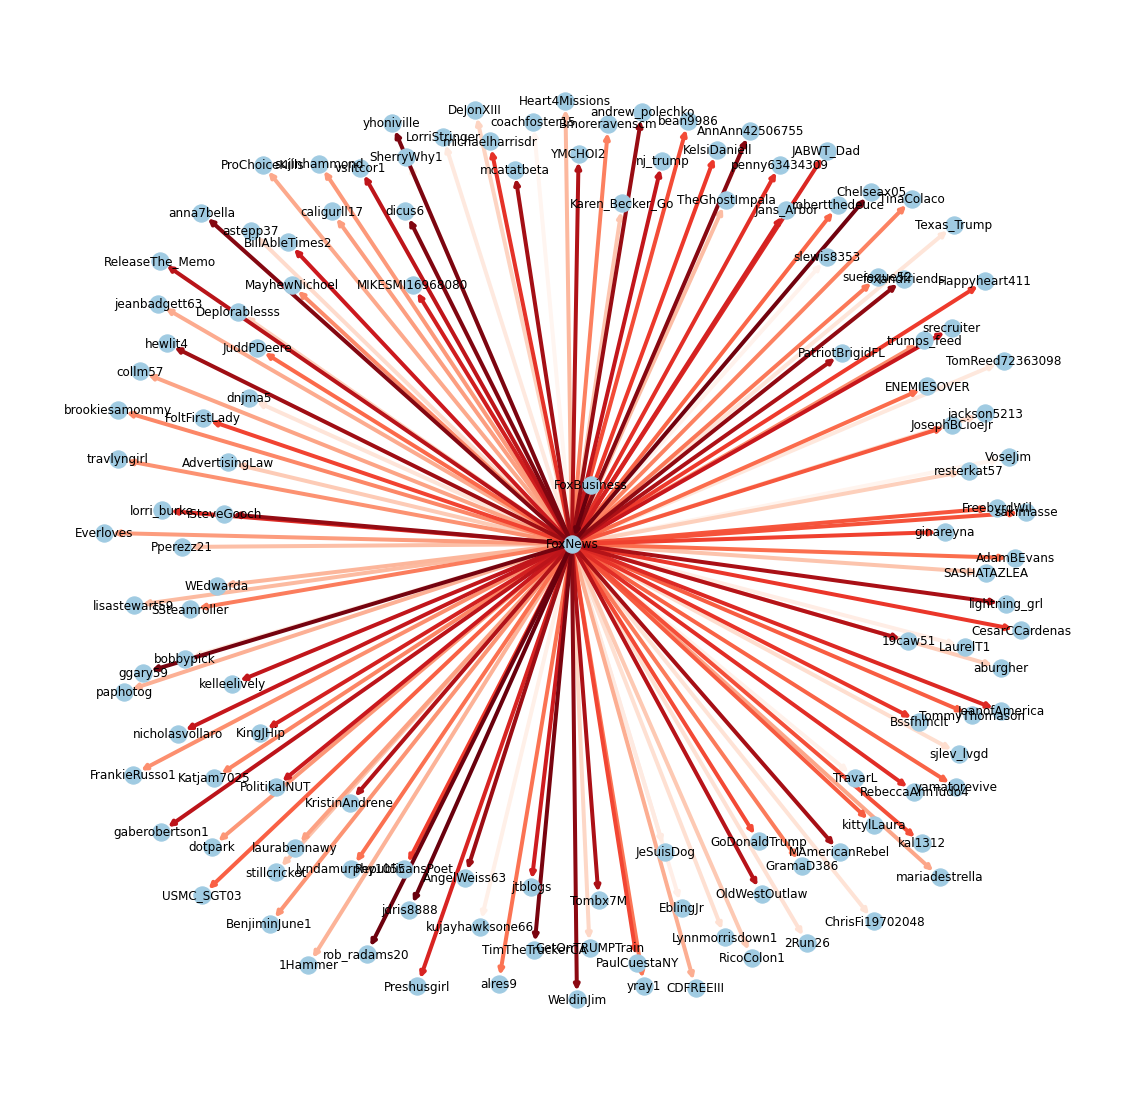

In [8]:
plt.figure(figsize=(20,20))
pos = nx.spring_layout(G_rt, k=0.20, iterations=20)
colors = range(129)
nx.draw_networkx(G_rt, pos, arrows=True, node_color='#A0CBE2', edge_color=colors, width=4, edge_cmap=plt.cm.Reds, with_labels=True)
plt.axis('off')
plt.show()

## Part C: Degree Centrality

We create another graph, but this time with the whole dataset from the initial csv file. However, we use the same source, target and graph type, being the retweeted account, the account that retweets, and directed graph, respectively.

In [9]:
G_rt_full = nx.from_pandas_edgelist(sotu_retweets, source='retweeted_status-user-screen_name', target='user-screen_name', create_using=nx.DiGraph())

We now check the top five users who retweeted the most according to their in-degree centrality. 

In [10]:
in_centrality_dict = nx.in_degree_centrality(G_rt_full)
in_centrality_tup = [(key, value) for key, value in in_centrality_dict.items()]
in_centrality_sorted = sorted(in_centrality_tup, key=lambda pair: pair[1], reverse=True)
in_centrality_sorted[:5]

[('nljac000', 0.0021872265966754157),
 ('thedreadedaw', 0.0017497812773403325),
 ('debra_bonanno', 0.0017497812773403325),
 ('aedaw9i', 0.0017497812773403325),
 ('SteveJa39296543', 0.0017497812773403325)]

We also check the top five accounts who were retweeted the most according to their out-degree centrality. 

In [11]:
out_centrality_dict = nx.out_degree_centrality(G_rt_full)
out_centrality_tup = [(key, value) for key, value in out_centrality_dict.items()]
out_centrality_sorted = sorted(out_centrality_tup, key=lambda pair: pair[1], reverse=True)
out_centrality_sorted[:5]

[('FoxNews', 0.05599300087489064),
 ('WhiteHouse', 0.031058617672790903),
 ('ScottPresler', 0.029746281714785654),
 ('TomiLahren', 0.01968503937007874),
 ('KyleKulinski', 0.01706036745406824)]

## Part D: Betweenness Centrality

We check the top five accounts with the highest betweenness centrality, which means the accounts that would interrupt the most shortest paths if they were removed. This could also mean that these accounts are the most relevant for connecting different nodes. 

In [12]:
rt_centrality = nx.betweenness_centrality(G_rt_full)
between_centrality_tup = [(key, value) for key, value in rt_centrality.items()]
between_centrality_sorted = sorted(between_centrality_tup, key=lambda pair: pair[1], reverse=True)
between_centrality_sorted[:5]

[('FoxNews', 2.5653248486171177e-05),
 ('Public_Citizen', 9.189223338329973e-06),
 ('ChristiChat', 5.16893812781061e-06),
 ('guypbenson', 4.594611669164987e-06),
 ('johncardillo', 4.020285210519363e-06)]

We plot the full network of retweets given in the dataset. We can see that the yellow node is FoxNews, because it has the highest number of outward edges, and it is also the biggest, because it is the account with the highest betweenness centrality. 

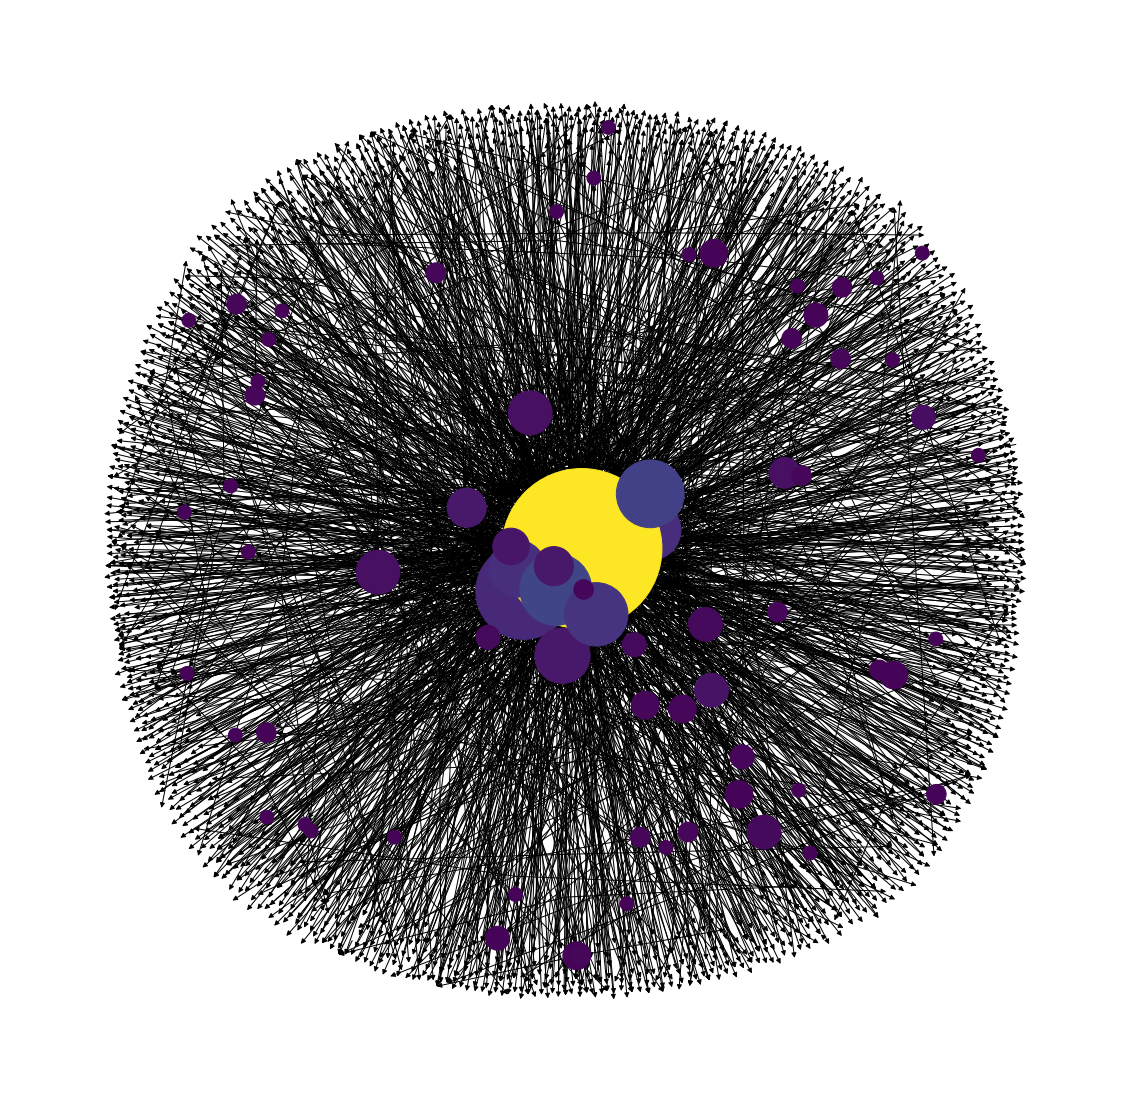

In [13]:
node_color = [200_000_000.0 * G_rt_full.out_degree(v) for v in G_rt_full]
node_size = [v * 1_000_000_000 for v in rt_centrality.values()]
plt.figure(figsize=(20,20))
nx.draw_networkx(G_rt_full, with_labels=False, node_color=node_color, node_size=node_size)
plt.axis('off')
plt.show()

We want to generate a word cloud in the next step, so first we have to clean the tweets and join all of them into a single text. We then show this text to check if the transformations were done correctly.

In [14]:
clean_text = sotu_retweets_fox.text.apply(lambda text: clean(text))
all_text = ' '.join(clean_text)
all_text

': .: "Terrorists who do things like place bombs in civilian hospitals are evil. When possible, we have no choice but to an : .: "For decades, open borders have allowed drugs and gangs to pour into our most vulnerable communities. They have allow : .: "We celebrate our police, our military, and our amazing veterans as heroes who deserve our total and unwavering suppo : .: Lets begin tonight by recognizing that the state of our union is strong because our people are strong. https : .: "We repealed the core of disastrous : the individual mandate is now gone." ht : DJT: "We face rogue regimes, terrorist groups, &amp; rivals like China &amp; Russia that challenge our interests, our economy, &amp; our v : .: "In America, we know that faith and family, not government and bureaucracy, are the center of American life. The mot : .: "Mr. Speaker, Mr. Vice President, Members of Congress, , and my fellow Americans - less than year has passed : . signs a hat. . : Watch: President Donald Trump deliv

We define the stopwords and add a few more that might still be present in the tweets. We then show the word cloud with the most common words found in the tweets, however, after removing the stopwords. By looking at the word cloud, we can see that the main topic of the tweets is about politics. 

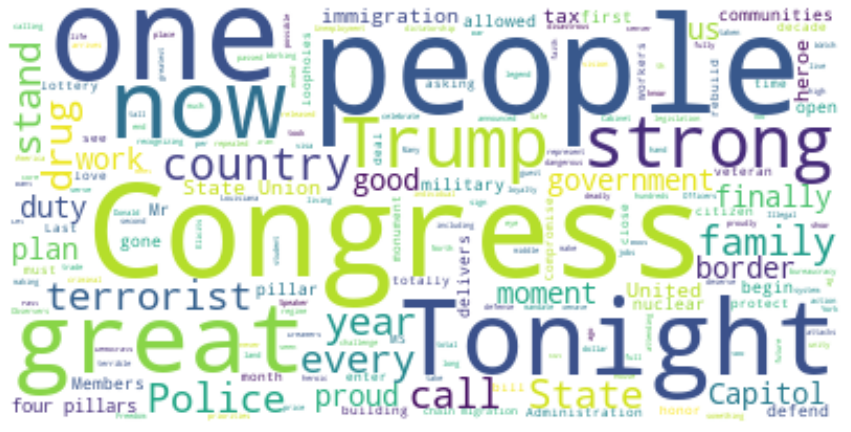

In [15]:
stopwords = set(STOPWORDS)
stopwords.update(['https', 'amp', 'america', 'american', 'americans', 'president', 'will', 'address', 'new'])
plt.figure(figsize=(15,15))
wordcloud = WordCloud(stopwords=stopwords, background_color='white').generate(all_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()